In [1]:
import pandas as pd
import numpy as np
import data
import matplotlib.pyplot as plt

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
target = data.clean_data('../data/clean_transactions.csv')
target = target.iloc[1064:,:-8]

In [3]:
mean = 188.4318877714359
variance = 120971.63484231419
stdd = np.sqrt(variance)

df = pd.read_parquet('transformers_results_v2.parquet')
df = (df * stdd) + mean
df = df.where(df > 0, 0)

In [4]:
target.shape

(158536, 147)

In [5]:
def _validate_target_predicted(target, predicted):
    """
    Validates target and predicted data. Both arguments 
    must have the same shape. If argument is a DataFrame, 
    this function converts it to a numpy array. 
    """
    
    if isinstance(target, pd.DataFrame) or isinstance(target, pd.Series):
        target = target.values
        
    if isinstance(predicted, pd.DataFrame) or isinstance(predicted, pd.Series):
        predicted = predicted.values
    
    assert isinstance(target, np.ndarray)
    assert isinstance(predicted, np.ndarray)
    assert target.shape == predicted.shape
    
    return target, predicted

def MAAPE(target, predicted, axis = None):
    """ Mean Abosulute Arctangent Percentual Error """
    target, predicted = _validate_target_predicted(target, predicted)
    
    return np.arctan(np.abs((target - predicted)/(target + 1e-9))).mean(axis = axis)

def wMAPE(target, predicted, axis = None):
    """ Weighted Mean Abosulute Percentual Error """
    target, predicted = _validate_target_predicted(target, predicted)
    
    num = np.abs(target - predicted).sum(axis = axis)
    dem = np.abs(target).sum(axis = axis)
    return num/dem

def sMAPE(target, predicted, axis = None):
    """ symetric Mean Abosulute Percentual Error """
    target, predicted = _validate_target_predicted(target, predicted)
    
    num = np.abs(target-predicted)
    dem = np.abs(target) + np.abs(predicted)
    return np.nan_to_num(num/dem).mean(axis = axis)

def bootstrap_std(target, predicted, func):
    """ Bootsrap function to estimate the standard error of 'func'
    
    Parameters: 
    - target: 1-d array-like. Target data of size n
    - predicted: 1-d array-like. Predicted data of size n
    - func: func. inputs of the function are target, predicted and axis. 
    
    Return: 
    estimated standard error of 'func' via bootstrap. 
    """
    target, predicted = _validate_target_predicted(target, predicted)
    target = target.flatten()
    predicted = predicted.flatten()
    
    indices = np.random.choice(target.size, size = (1000,1000), replace=True)
    target_sample = target[indices]
    predicted_sample = predicted[indices]
    
    return func(target_sample, predicted_sample, axis = 1).std()

def summary_erros(target, predictions):
    """
    Summary table for accuracy metrics
    
    Parameters:
    - target: 
    - predictions: list. List of dataframes. Each dataframe 
                   must contain df.name where name is the the 
                   model where the prediction is from. 
    """
    
    assert isinstance(predictions, list)
    error_list = [MAAPE, wMAPE, sMAPE]
    error_name = ['MAAPE', 'wMAPE', 'sMAPE']
    results = {}
    
    for p in predictions:
        model = p.name
        error_dict = {}
        for func, name in zip(error_list, error_name):
            error = func(target, p)
            std = bootstrap_std(target, p, func)
            error_dict[name] = "{:.2f} (\u00B1{:.3f})".format(error,1.96*std)
        
        results[model] = error_dict
        
    print(pd.DataFrame(results).T.style.to_latex(caption = 'Summary accuracy metrics', 
                                                 position_float='centering', 
                                                 hrules = True))
    
    
def error_plots(target, predictions, stations, start_date, end_date, func, func_name, 
                 rolling_period = 76):
    
    # Estimate error of stations
    results = []
    for station in stations: 
        df_dict = {}
        for prediction in predictions:
            prediction_name = prediction.name
            values = func(target[[station]], prediction[[station]], axis = 1)
            df_dict[prediction_name] = values

        df = pd.DataFrame(df_dict, index = target.index)
        df.name = station
        results.append(df)
        
    #Plot
    fig, axs = plt.subplots(nrows = len(results), figsize = (20,20))
    for i, s in enumerate(results):
        s[start_date:end_date].rolling(rolling_period).mean().plot(ax = axs[i])
        axs[i].set_title(s.name, fontsize = 20)
        axs[i].set_xlabel('')
        axs[i].set_ylabel(func_name, fontsize = 20)
        axs[i].tick_params(labelrotation=0)
        
def target_prediction_plot(target, prediction, stations, start_date, end_date):
    
    fig, axs = plt.subplots(nrows = len(stations), figsize = (20,20))
    
    for i, station in enumerate(stations):
        target[station][start_date:end_date].plot(ax = axs[i], legend = True, label = 'Target')
        prediction[station][start_date:end_date].plot(ax = axs[i], 
                                                      legend = True, 
                                                      label = 'Prediction: {}'.format(prediction.name))
        axs[i].set_title(station, fontsize = 20)
        axs[i].set_xlabel('')
        axs[i].set_ylabel('Demand', fontsize = 20)
        axs[i].tick_params(labelrotation=0)

In [6]:
stable_target = target#[83296:127000]
stable_predicted = df #[83296:127000]
stable_predicted.name = "transaformer_stable"

summary_erros(stable_target, [stable_predicted])

<ipython-input-5-fc9abd66af34>:40: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(num/dem).mean(axis = axis)


\begin{table}
\centering
\caption{Summary accuracy metrics}
\begin{tabular}{llll}
\toprule
 & MAAPE & sMAPE & wMAPE \\
\midrule
transaformer_stable & 0.37 (±0.025) & 0.20 (±0.015) & 0.18 (±0.018) \\
\bottomrule
\end{tabular}
\end{table}



In [7]:
stable_target = target[83296:127000]
stable_predicted = df[83296:127000]
stable_predicted.name = "transaformer_stable"

summary_erros(stable_target, [stable_predicted])

\begin{table}
\centering
\caption{Summary accuracy metrics}
\begin{tabular}{llll}
\toprule
 & MAAPE & sMAPE & wMAPE \\
\midrule
transaformer_stable & 0.34 (±0.023) & 0.18 (±0.014) & 0.17 (±0.017) \\
\bottomrule
\end{tabular}
\end{table}



<ipython-input-5-fc9abd66af34>:40: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(num/dem).mean(axis = axis)


In [8]:
covid_target = target[127000:]
covid_predicted = df[127000:]
covid_predicted.name = "transaformer_stable"

summary_erros(covid_target, [covid_predicted])

\begin{table}
\centering
\caption{Summary accuracy metrics}
\begin{tabular}{llll}
\toprule
 & MAAPE & sMAPE & wMAPE \\
\midrule
transaformer_stable & 0.58 (±0.028) & 0.31 (±0.017) & 0.42 (±0.051) \\
\bottomrule
\end{tabular}
\end{table}



<ipython-input-5-fc9abd66af34>:40: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(num/dem).mean(axis = axis)


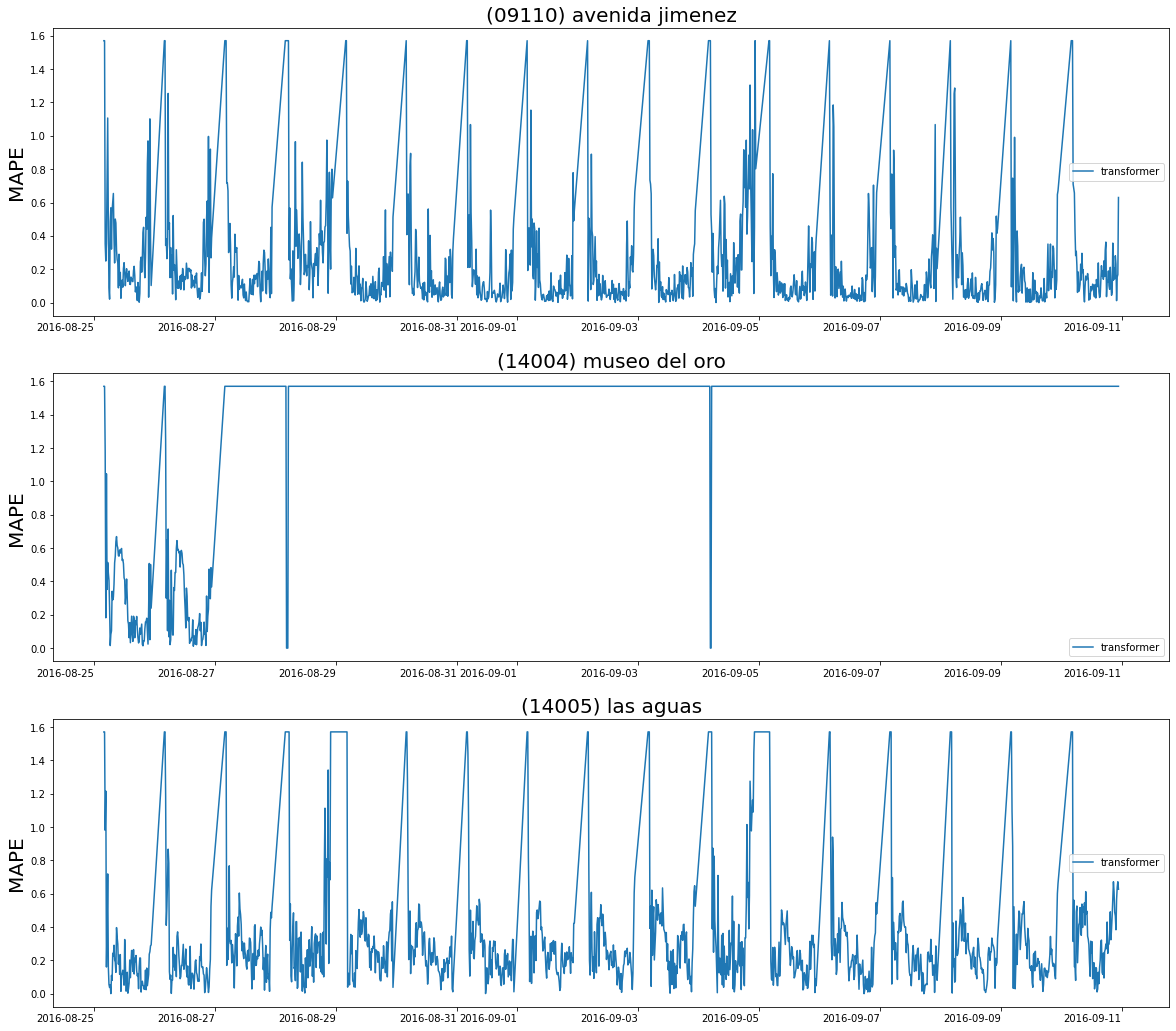

In [9]:
stations = ['(09110) avenida jimenez','(14004) museo del oro', '(14005) las aguas']
errors = [MAAPE, wMAPE, sMAPE]
errors_name = ['MAAPE', 'wMAPE', 'sMAPE']
models = [df]
df.name = "transformer"

# error_plots(target, df, stations, start_date, end_date, func, func_name, 
#                  rolling_period = 76)

error_plots(target, 
            predictions = [df],
            stations = ['(09110) avenida jimenez','(14004) museo del oro', '(14005) las aguas'],
            start_date = '2016-08-25', 
            end_date = '2016-09-10',
            func = MAAPE, 
            func_name = 'MAPE', 
            rolling_period = 1,
           )

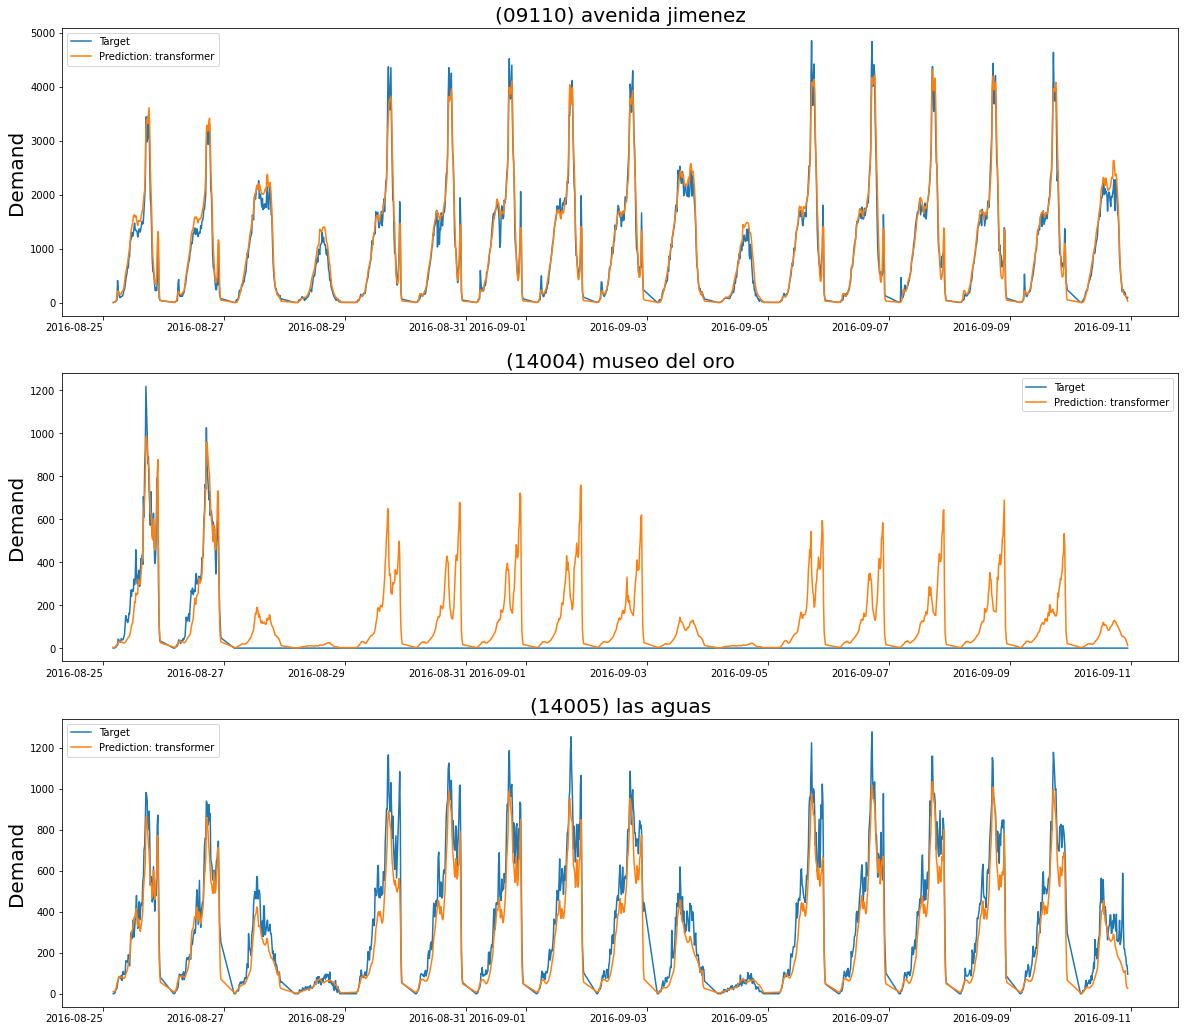

In [10]:
stations = ['(09110) avenida jimenez','(14004) museo del oro', '(14005) las aguas']
errors = [MAAPE, wMAPE, sMAPE]
errors_name = ['MAAPE', 'wMAPE', 'sMAPE']
# models = [r1,r2,r3]
df.name = "transformer"

target_prediction_plot(target, 
                       df, 
                       stations, 
                       start_date = '2016-08-25', 
                       end_date = '2016-09-10')

In [11]:
target

,(02000) cabecera autopista norte,(02001) centro comercial santa fe,(02101) toberin,(02102) calle 161,(02103) mazuren,(02104) calle 146,(02105) calle 142,(02200) alcala,(02201) prado,(02202) calle 127,...,(12000) puente aranda,(12001) carrera 43,(12002) cds - carrera 32,(12003) ricaurte,(12004) carrera 22,(12007) zona industrial,(14001) la sabana,(14004) museo del oro,(14005) las aguas,(07010) bosa
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-08-15 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-08-15 04:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-08-15 04:30:00,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0
2015-08-15 04:45:00,173.0,0.0,18.0,1.0,2.0,0.0,0.0,8.0,10.0,0.0,...,3.0,3.0,8.0,17.0,4.0,5.0,6.0,4.0,3.0,0.0
2015-08-15 05:00:00,367.0,0.0,32.0,2.0,10.0,0.0,48.0,52.0,26.0,8.0,...,6.0,5.0,16.0,12.0,5.0,4.0,3.0,5.0,10.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30 21:45:00,7.0,2.0,1.0,1.0,0.0,9.0,2.0,50.0,8.0,8.0,...,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0
2021-04-30 22:00:00,19.0,1.0,5.0,2.0,0.0,3.0,8.0,18.0,4.0,5.0,...,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,3.0,0.0
2021-04-30 22:15:00,27.0,7.0,1.0,5.0,0.0,1.0,2.0,12.0,2.0,5.0,...,0.0,4.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
target_prediction_plot(target, prediction, stations, start_date, end_date)

NameError: name 'prediction' is not defined